In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import libertem
from libertem import api

In [4]:
ctx = api.Context()

In [5]:
ds = ctx.load(
    "empad",
    path="/Users/weber/cachedata/acquisition_12.xml",
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))
cx = detector_x/2
cy = detector_y/2
y = scan_y//2
x = scan_x//2

In [6]:
pick_analysis = ctx.create_pick_analysis(dataset=ds, x=x, y=y)

In [7]:
%time pick_result = ctx.run(pick_analysis)

CPU times: user 44.8 ms, sys: 13.1 ms, total: 57.9 ms
Wall time: 238 ms


In [8]:
print(pick_result)

[<AnalysisResult: intensity>]


In [9]:
print(pick_result.intensity)

title: intensity
desc: the frame at x=128 y=128
key: intensity
raw_data: [[-8.13885784e+00  2.78387146e+02  1.21861145e+02 ... -4.40790081e+00
   9.17510700e+00  3.61393127e+02]
 [ 3.34319031e+02  8.81300659e+01  1.34341402e+01 ...  5.24505329e+00
   3.87167053e+02  3.15179138e+02]
 [ 1.89738098e+02  4.52169128e+02  2.16744080e+02 ...  5.01070023e-02
   2.24602985e+00  6.64280396e+01]
 ...
 [ 1.97808552e+00 -1.16095257e+00  3.79803181e+00 ... -1.31293011e+00
  -4.03290081e+00  8.70181274e+01]
 [ 3.93348083e+02  1.71770592e+01 -4.50995159e+00 ...  4.24455139e+02
   7.21014118e+00 -8.62856865e-01]
 [ 3.91654114e+02  1.70341148e+01 -5.51288128e+00 ...  4.23157043e+02
   6.54009724e+00 -7.03921318e-01]]
visualized: [[[ 48 128 126 255]
  [121 166  82 255]
  [ 82 157  72 255]
  ...
  [ 50 131 120 255]
  [ 56 137 106 255]
  [131 169  84 255]]

 [[128 168  83 255]
  [ 69 153  72 255]
  [ 57 139 103 255]
  ...
  [ 54 136 110 255]
  [133 169  84 255]
  [126 167  83 255]]

 [[104 163  78 255]
  [

<IPython.core.display.Javascript object>


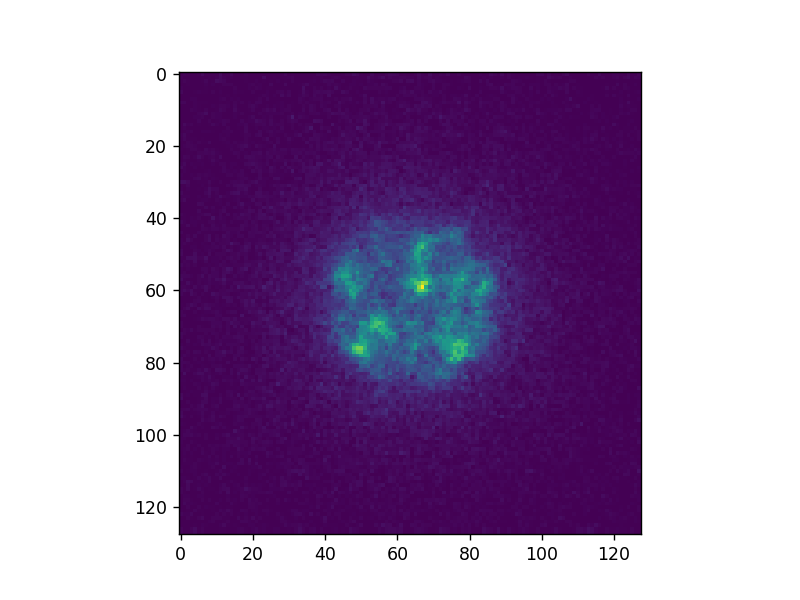

In [10]:
fig, axes = plt.subplots()
axes.imshow(pick_result.intensity.raw_data)

In [11]:
def all_ones():
    return np.ones((detector_y, detector_x))

In [12]:
def single_pixel():
    buf = np.zeros((detector_y, detector_x))
    buf[int(cy), int(cx)] = 1
    return buf

Here we use a mask UDF. This UDF uses the LiberTEM computation rather directly and returns a simple numerical result. See further below for examples that use the high-level analysis interface instead.

In [13]:
mask_udf = libertem.udf.masks.ApplyMasksUDF(mask_factories=[all_ones, single_pixel])

In [14]:
%%time
mask_udf_result = ctx.run_udf(dataset=ds, udf=mask_udf)

CPU times: user 542 ms, sys: 64.2 ms, total: 606 ms
Wall time: 2 s


In [15]:
print(mask_udf_result)

{'intensity': <BufferWrapper kind=nav dtype=float64 extra_shape=(2,)>}


In [16]:
print(mask_udf_result['intensity'])

<BufferWrapper kind=nav dtype=float64 extra_shape=(2,)>


<IPython.core.display.Javascript object>


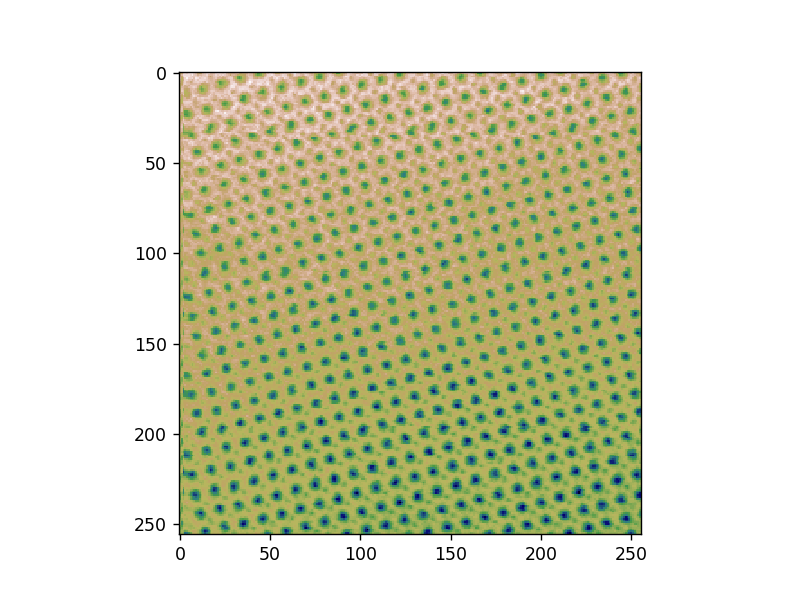

In [17]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 0], cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


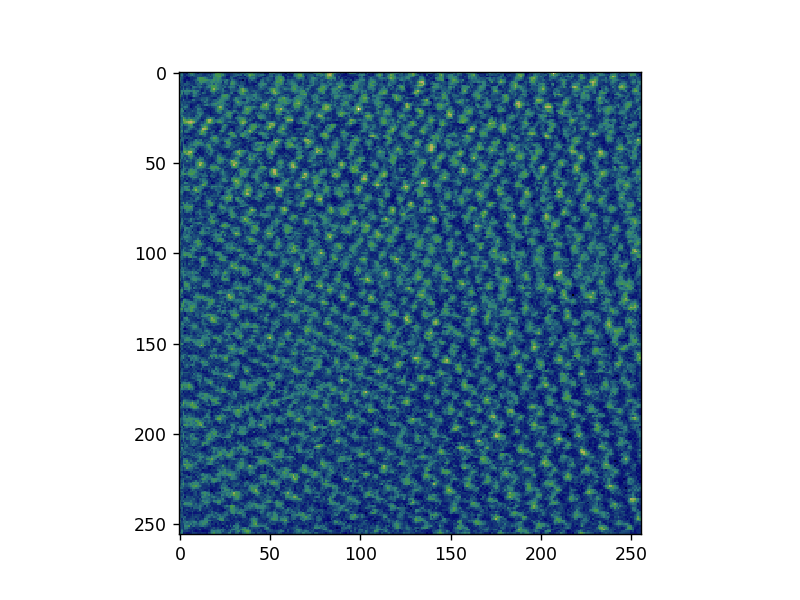

In [18]:
fig, axes = plt.subplots()
axes.imshow(mask_udf_result['intensity'].data[..., 1], cmap=cm.gist_earth)

In [19]:
mask_analysis = ctx.create_mask_analysis(dataset=ds, factories=[all_ones, single_pixel])

In [20]:
%time mask_analysis_result = ctx.run(mask_analysis)

CPU times: user 350 ms, sys: 43.2 ms, total: 394 ms
Wall time: 1.16 s


In [21]:
print(mask_analysis_result)

[<AnalysisResult: mask_0>, <AnalysisResult: mask_1>]


In [22]:
print(mask_analysis_result[0])

title: mask 0
desc: integrated intensity for mask 0
key: mask_0
raw_data: [[27850324.46470737 28474082.45085371 29206838.67937374 ...
  28496849.76693916 28388546.92699718 28217773.00704062]
 [28612171.70658779 28955478.90611744 29521825.3988533  ...
  28629364.43827248 28697176.76654625 28371276.06541061]
 [28774531.51028061 28422556.40788412 29332136.66587257 ...
  28734413.25531101 28855773.94640541 28983199.20615196]
 ...
 [26167279.02553844 27059745.25436211 27660706.17696774 ...
  27118113.38793564 27208242.42211914 27266392.25596046]
 [26604566.99832344 27274427.70754623 27053773.30085039 ...
  26818205.96283722 26966513.04644966 26932802.87919855]
 [26721508.96784973 27176442.7510376  26789558.92479277 ...
  26511140.42865658 27037473.06530333 27278705.8884002 ]]
visualized: [[[186 175  96 255]
  [200 166 120 255]
  [229 199 187 255]
  ...
  [201 167 123 255]
  [197 164 113 255]
  [191 164 100 255]]

 [[206 171 132 255]
  [219 183 162 255]
  [241 222 220 255]
  ...
  [207 172 1

<IPython.core.display.Javascript object>


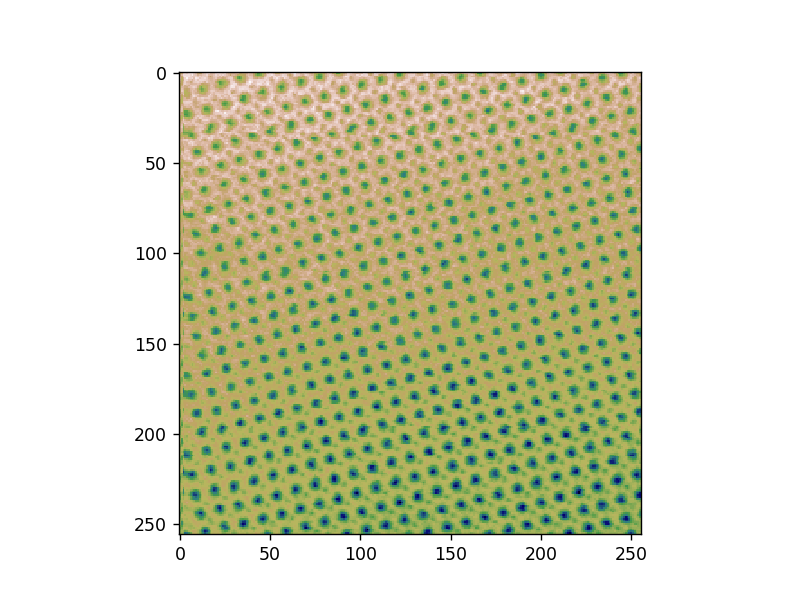

In [23]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[0].visualized)

<IPython.core.display.Javascript object>


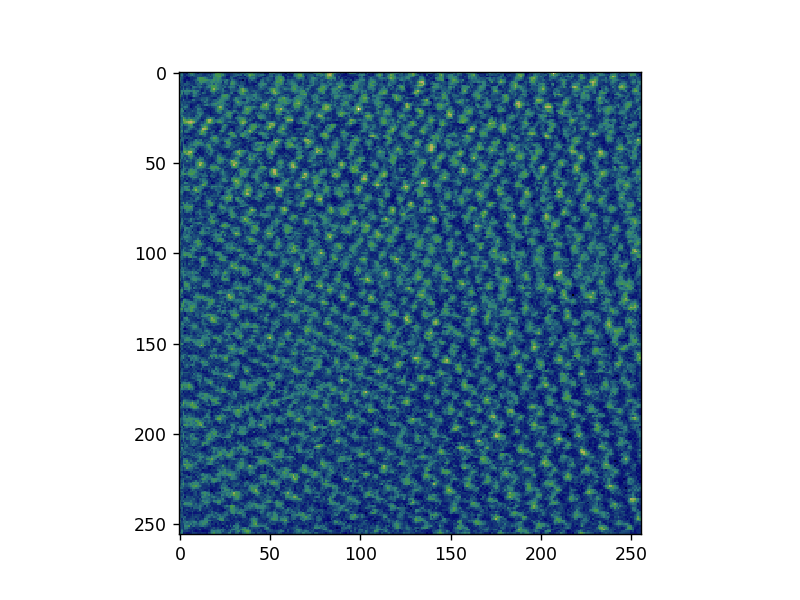

In [24]:
fig, axes = plt.subplots()
axes.imshow(mask_analysis_result[1].visualized)

In [25]:
ro = min(detector_x,detector_y)/2
haadf_analysis = ctx.create_ring_analysis(dataset=ds, cx=cx, cy=cy, ro=ro, ri=ro*0.8)

In [26]:
%time haadf_result = ctx.run(haadf_analysis)

CPU times: user 294 ms, sys: 19.9 ms, total: 314 ms
Wall time: 468 ms


In [27]:
print(haadf_result)

[<AnalysisResult: intensity>]


In [28]:
print(haadf_result.intensity)

title: intensity
desc: intensity of the integration over the selected ring
key: intensity
raw_data: [[1430498.  1472583.  1331891.  ... 1406989.  1441294.2 1464622.4]
 [1390670.4 1441177.  1347792.8 ... 1302910.8 1314042.1 1347872.9]
 [1407068.  1564187.2 1444740.2 ... 1396887.9 1321350.8 1317518.6]
 ...
 [1905181.5 1706497.4 1620345.2 ... 1792412.9 1785900.5 1752097. ]
 [1795231.2 1651401.  1675191.5 ... 1867160.8 1833695.2 1820662. ]
 [1758157.9 1666727.5 1691829.8 ... 1918685.2 1812730.2 1776172.4]]
visualized: [[[ 38 105 125 255]
  [ 43 118 126 255]
  [ 25  69 121 255]
  ...
  [ 35  97 124 255]
  [ 39 109 125 255]
  [ 43 116 126 255]]

 [[ 33  92 123 255]
  [ 39 109 125 255]
  [ 27  75 121 255]
  ...
  [ 21  56 120 255]
  [ 22  60 120 255]
  [ 27  75 121 255]]

 [[ 35  97 124 255]
  [ 54 135 111 255]
  [ 40 110 125 255]
  ...
  [ 33  94 123 255]
  [ 23  64 121 255]
  [ 23  62 120 255]]

 ...

 [[145 172  86 255]
  [ 67 152  76 255]
  [ 59 141  98 255]
  ...
  [102 162  77 255]
  [ 

<IPython.core.display.Javascript object>


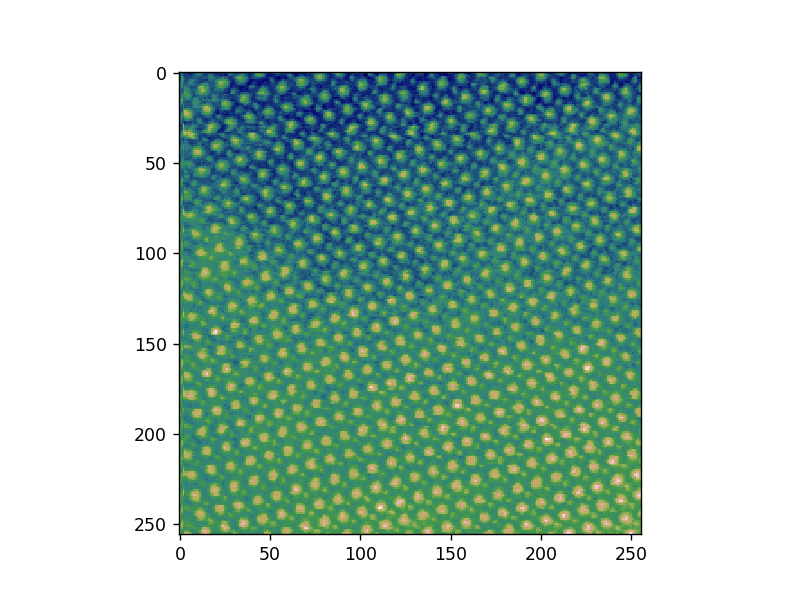

In [29]:
fig, axes = plt.subplots()
axes.imshow(haadf_result.intensity.visualized)

In [30]:
bf_analysis = ctx.create_disk_analysis(dataset=ds, cx=cx, cy=cy, r=ro*0.3)

In [31]:
%time bf_result = ctx.run(bf_analysis)

CPU times: user 254 ms, sys: 12.8 ms, total: 267 ms
Wall time: 390 ms


In [32]:
print(bf_result)

[<AnalysisResult: intensity>]


In [33]:
print(bf_result.intensity)

title: intensity
desc: intensity of the integration over the selected disk
key: intensity
raw_data: [[11855892. 12050526. 13056826. ... 12369484. 11876224. 11598536.]
 [12859636. 12649295. 13449516. ... 12338372. 12118210. 11864102.]
 [13009234. 11589958. 12699814. ... 12133116. 12087128. 12033631.]
 ...
 [ 9925932. 10641335. 11301421. ... 10896897. 11075714. 11224716.]
 [10470584. 11345229. 10838044. ... 10156356. 10719042. 10770758.]
 [10751518. 11299931. 10408881. ...  9766377. 10741134. 10775174.]]
visualized: [[[173 180  92 255]
  [181 182  93 255]
  [199 166 118 255]
  ...
  [186 175  96 255]
  [173 180  92 255]
  [159 176  89 255]]

 [[192 163 103 255]
  [190 168  99 255]
  [212 176 147 255]
  ...
  [186 175  96 255]
  [183 181  94 255]
  [173 180  92 255]]

 [[198 165 115 255]
  [159 176  89 255]
  [190 167  99 255]
  ...
  [183 181  94 255]
  [182 182  94 255]
  [181 182  93 255]]

 ...

 [[ 67 152  76 255]
  [111 164  79 255]
  [145 172  86 255]
  ...
  [125 167  82 255]
  [1

<IPython.core.display.Javascript object>


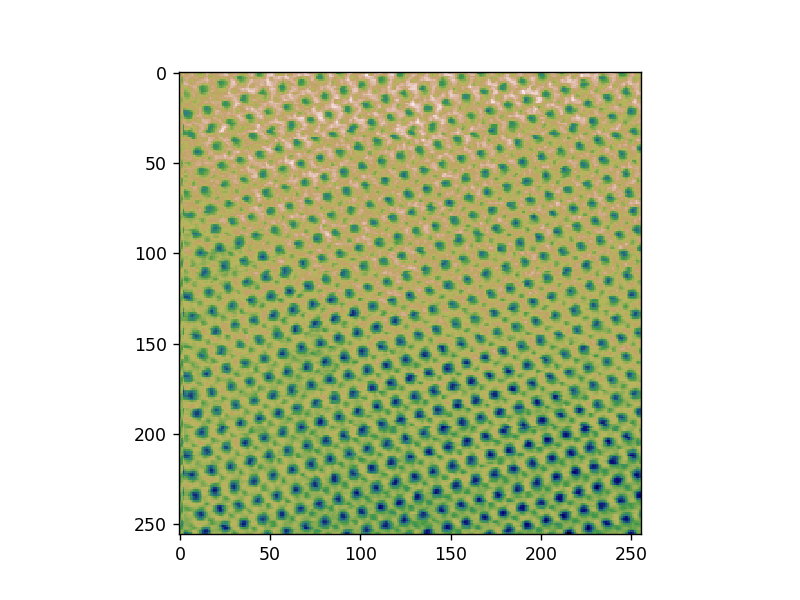

In [34]:
fig, axes = plt.subplots()
axes.imshow(bf_result.intensity.visualized)

In [35]:
point_analysis = ctx.create_point_analysis(dataset=ds, x=cx, y=cy)

In [36]:
%time point_result = ctx.run(point_analysis)

CPU times: user 331 ms, sys: 30 ms, total: 361 ms
Wall time: 698 ms


In [37]:
print(point_result)

[<AnalysisResult: intensity>]


In [38]:
print(point_result.intensity)

title: intensity
desc: intensity of the integration over the selected point
key: intensity
raw_data: [[ 9863.201  11829.065   6490.724  ...  7891.671   6461.673   6609.272 ]
 [11411.631  13569.099   7547.4136 ...  8430.884   8433.084   4680.7437]
 [10615.64   10571.748   7038.782  ... 12167.771   7040.497   7997.6006]
 ...
 [ 7091.531  11770.922   7214.841  ...  5467.903   5994.1973  6137.106 ]
 [ 7214.639  15155.479   8181.688  ...  5985.63    6306.6313  6185.5386]
 [10637.375  13987.006   5301.716  ...  4848.8687  6378.0674  6715.919 ]]
visualized: [[[ 30  84 122 255]
  [ 37 104 124 255]
  [ 17  45 119 255]
  ...
  [ 23  62 120 255]
  [ 17  43 119 255]
  [ 17  45 119 255]]

 [[ 36 101 124 255]
  [ 44 120 126 255]
  [ 21  58 120 255]
  ...
  [ 25  69 121 255]
  [ 25  69 121 255]
  [ 10  20 117 255]]

 [[ 33  92 123 255]
  [ 33  92 123 255]
  [ 19  52 119 255]
  ...
  [ 39 107 125 255]
  [ 19  52 119 255]
  [ 23  62 120 255]]

 ...

 [[ 19  52 119 255]
  [ 37 104 124 255]
  [ 20  54 12

<IPython.core.display.Javascript object>


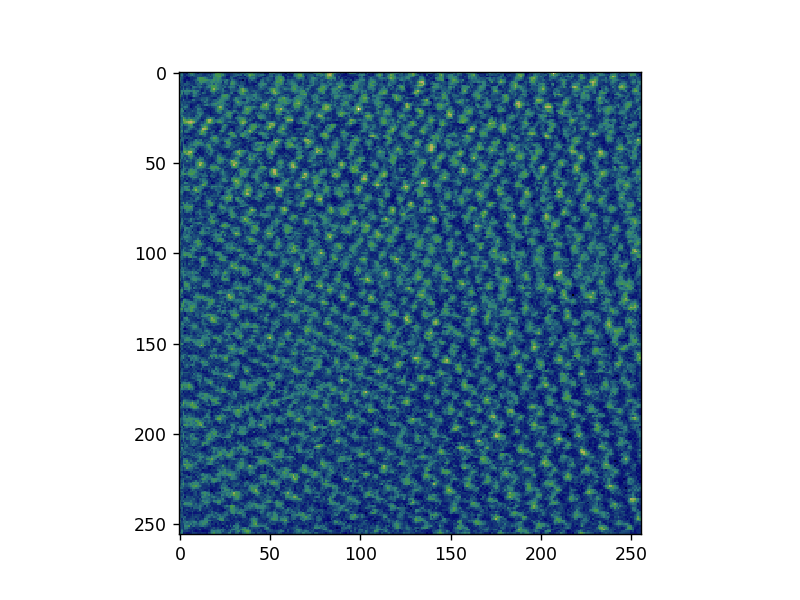

In [39]:
fig, axes = plt.subplots()
axes.imshow(point_result.intensity.visualized)

In [40]:
sum_analysis = ctx.create_sum_analysis(dataset=ds)

In [41]:
%time sum_result = ctx.run(sum_analysis)

CPU times: user 310 ms, sys: 52.8 ms, total: 363 ms
Wall time: 1.62 s


In [42]:
print(sum_result)

[<AnalysisResult: intensity>]


<IPython.core.display.Javascript object>


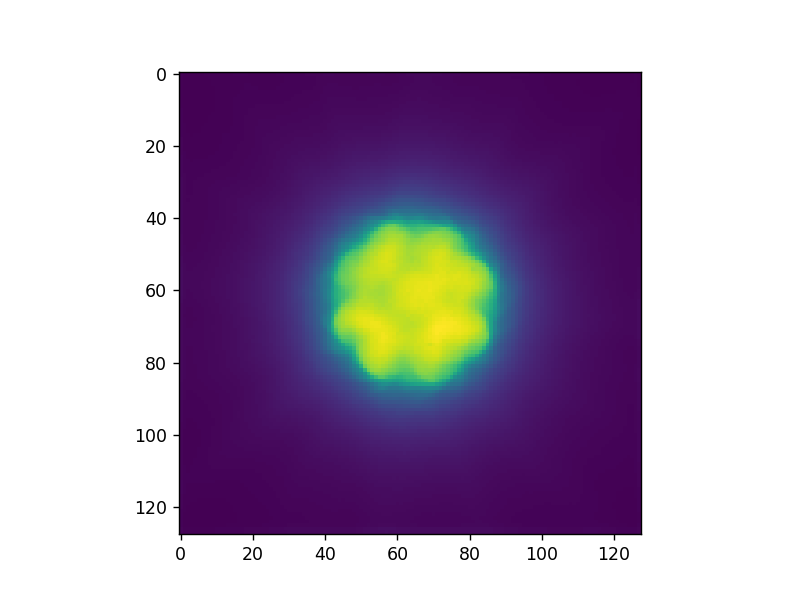

In [43]:
fig, axes = plt.subplots()
axes.imshow(sum_result.intensity.raw_data)